In [249]:
import torchhd
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import math
from functools import partial
import scipy.stats as stats

In [ ]:
import sys
sys.path.append('..')
from shared_code.helpers import similarity_func_partial

In [250]:
VSA_TYPES = ['FHRR', 'BSC', 'MAP', 'HRR']
DIMENSIONS = [2**i for i in range(8, 14)]
BUNDLE_SIZES = list(range(2, 200, 2))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    torch.cuda.empty_cache()

batches = 10
item_memory_size = 5_000
MAX_BUNDLE_SIZE = BUNDLE_SIZES[-1]

In [252]:
sim_tensors = torch.zeros(len(VSA_TYPES), len(DIMENSIONS), item_memory_size) # Store similarities between randomly generated vector and item memory (also randomly generated by definition) for each dimension and vsa type


for vsa_type_idx in tqdm(range(len(VSA_TYPES))):
  vsa_type = VSA_TYPES[vsa_type_idx]
  print(f'vsa type: {vsa_type}')
  similarity_func = partial(similarity_func_partial, vsa_type)


  for dim_idx in tqdm(range(len(DIMENSIONS))):
    dim = DIMENSIONS[dim_idx]

    item_memory = torchhd.random(item_memory_size, dim, vsa=vsa_type, device=device)

    reference_vector = torchhd.random(1, dim, vsa=vsa_type, device=device)

    similarities = similarity_func(reference_vector, item_memory)

    sim_tensors[vsa_type_idx, dim_idx, :] = similarities

  0%|          | 0/4 [00:00<?, ?it/s]

vsa type: FHRR


 25%|██▌       | 1/4 [00:00<00:00,  4.22it/s]

vsa type: BSC


100%|██████████| 6/6 [00:00<00:00, 768.14it/s]


vsa type: MAP


100%|██████████| 6/6 [00:00<00:00, 495.98it/s]


vsa type: HRR


100%|██████████| 4/4 [00:00<00:00, 14.58it/s]


### Historgam of similarities for each vsa type

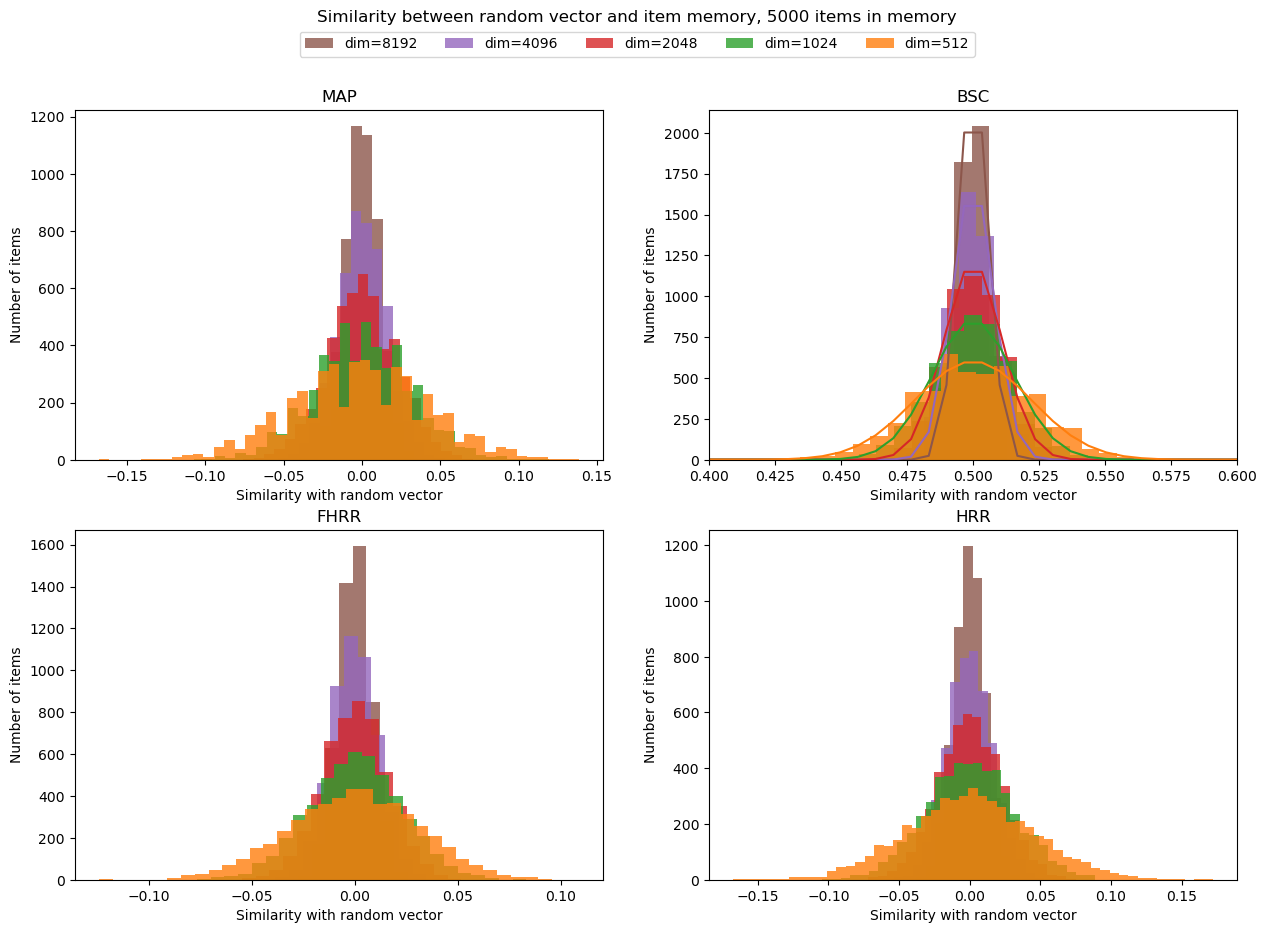

In [263]:
fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Similarity between random vector and item memory, {item_memory_size} items in memory')

bin_scale_factor = 150
for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = (vsa_type_idx+1) // 2 - 1
    col = vsa_type_idx % 2
    for dim_idx in range(len(DIMENSIONS)-1, 0, -1):
        data = sim_tensors[vsa_type_idx, dim_idx, :].cpu().numpy()
        ax[row, col].hist(data, alpha=0.8, label=f'dim={DIMENSIONS[dim_idx]}', bins=np.arange(min(data), max(data), 1/bin_scale_factor), color=f'C{dim_idx}')
        # plot theoretical similarity
        dim = DIMENSIONS[dim_idx]
        if vsa_type == 'BSC':
          x_axis = np.linspace(0, 1, bin_scale_factor)
          mean = 0.5
          ax[row, col].plot(x_axis, stats.norm.pdf(x_axis, loc=mean, scale=math.sqrt(0.5**2/dim))*item_memory_size/bin_scale_factor, label=f'theoretical similarity, dim={dim}', color=f'C{dim_idx}')
        
        

    ax[row, col].set_title(vsa_type)
    ax[row, col].set_xlabel('Similarity with random vector')
    ax[row, col].set_ylabel('Number of items')
    if vsa_type == 'BSC':
      ax[row, col].set_xlim(.4, .6)
    # ax[row, col].legend()
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(DIMENSIONS), loc='upper center', bbox_to_anchor=(0.5, .965))
# fig.legend(handles=ax[0, 0].get_lines(), labels=[f'dim={dim}' for dim in DIMENSIONS], ncol=len(DIMENSIONS), loc='upper center', bbox_to_anchor=(0.5, .95)) 

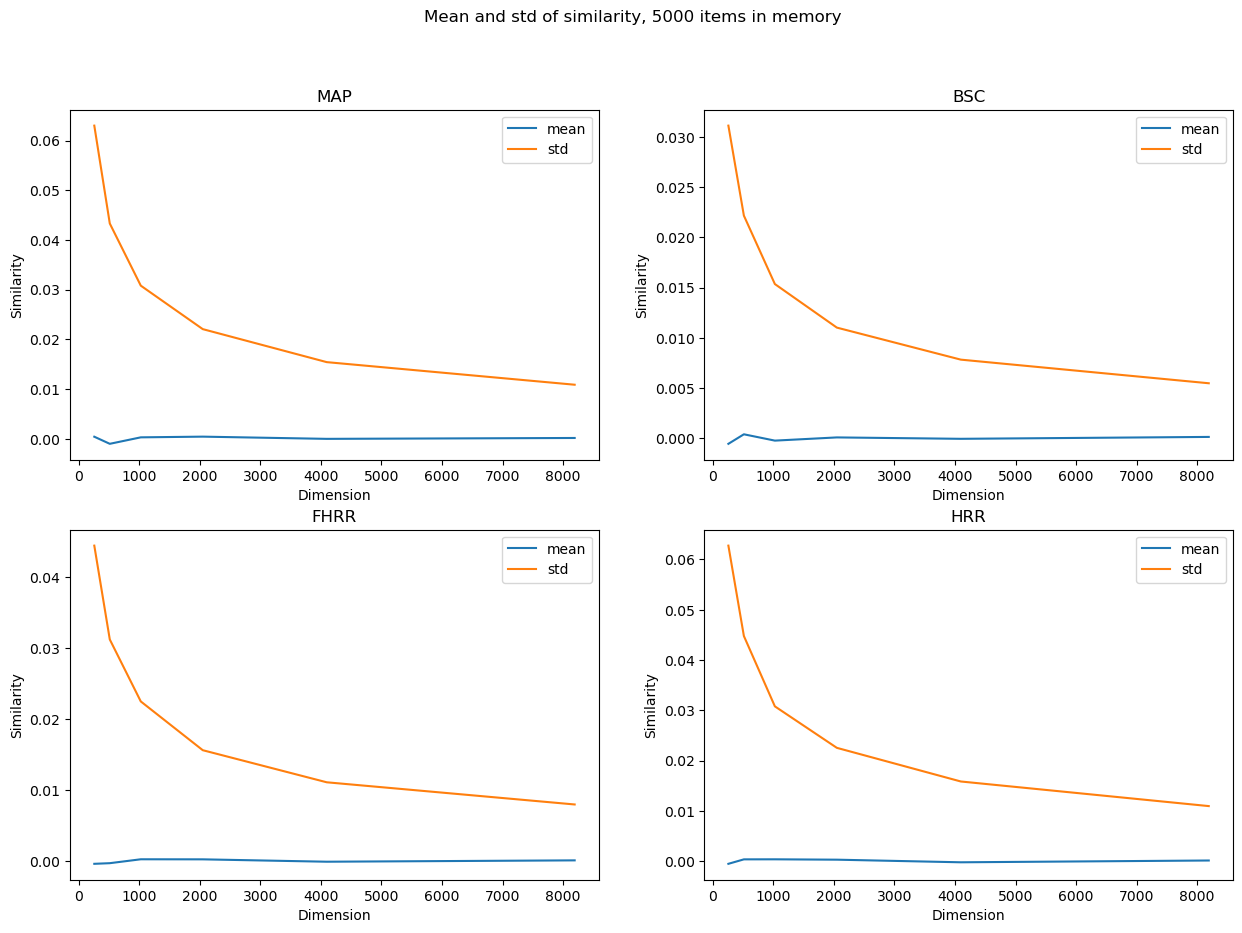

In [254]:
# Plotting mean and std of similarity for each vsa type

fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Mean and std of similarity, {item_memory_size} items in memory')

for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = (vsa_type_idx+1) // 2 - 1
    col = vsa_type_idx % 2
    mean_similarities = torch.mean(sim_tensors[vsa_type_idx, :, :], dim=1)
    #subtract 0.5 from mean if vsa type is BSC to ensure correct scale
    if vsa_type == 'BSC':
      mean_similarities -= 0.5
    std_similarities = torch.std(sim_tensors[vsa_type_idx, :, :], dim=1)
    ax[row, col].plot(DIMENSIONS, mean_similarities.cpu().numpy(), label='mean')
    ax[row, col].plot(DIMENSIONS, std_similarities.cpu().numpy(), label='std')
    ax[row, col].set_title(vsa_type)
    ax[row, col].set_xlabel('Dimension')
    ax[row, col].set_ylabel('Similarity')
    ax[row, col].legend()

Why does the normalization have such a big effect on the similarity for BSC and MAP HDVectors?
Normalization intoduces noice, especially for BSC and MAP HDVectors, which have only 2 possible values for each dimension. For MAP I believe a solid workaround is to use MAP-I instead of MAP-B, which is actually the default for torchhd.

In [255]:
vsa_type = 'MAP'


def seq_bundling(vecs):
    bundle_vec = vecs[0]
    for vec in vecs[1:]:
        bundle_vec = bundle_vec.bundle(vec)
        if type(vecs[0]) == torchhd.MAPTensor:
            bundle_vec = bundle_vec.clipping(1)
    return bundle_vec


dim = 10
amount_of_items = 5

identity_vecs = torchhd.identity(amount_of_items, dim, vsa=vsa_type) #identity for bind operation (all ones)
random_vecs = torchhd.random(amount_of_items, dim, vsa=vsa_type)

experiment_vecs = torch.vstack([identity_vecs, random_vecs])

_bundle = seq_bundling(experiment_vecs)
print(_bundle)
_multiset = torchhd.multiset(experiment_vecs)
if vsa_type == 'MAP':
    _multiset = _multiset.clipping(1)
print(_multiset)


dim = 500
amount_of_items = 10

identity_vecs = torchhd.identity(amount_of_items, dim, vsa=vsa_type) #identity for bind operation (all ones)
random_vecs = torchhd.random(amount_of_items, dim, vsa=vsa_type)

experiment_vecs = torch.vstack([identity_vecs, random_vecs])

_bundle = seq_bundling(experiment_vecs)
_multiset = torchhd.multiset(experiment_vecs)
if vsa_type == 'MAP':
    _multiset = _multiset.clipping(1)

sim_func = partial(similarity_func_partial, vsa_type)

_bundle_similarities = [sim_func(k, _bundle) for k in experiment_vecs]
_multiset_similarities = [sim_func(k, _multiset) for k in experiment_vecs]


# effect is exaggerated here by first bundling all identity vectors and then bundling the random vectors
# leading to the fact that the similarity to identity vectors is near 0 when we bundle sequentially
print(f'average similarity of sequential bundling: {torch.mean(torch.stack(_bundle_similarities))}')
print(f'average similarity of multiset: {torch.mean(torch.stack(_multiset_similarities))}')

MAPTensor([ 0., -1.,  1.,  0., -1., -1.,  1.,  0.,  1.,  0.])
MAPTensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])
average similarity of sequential bundling: MAPTensor(0.1128)
average similarity of multiset: MAPTensor(0.5110)


### Looking at normalisation of HRR vectors

In [256]:
import torch.nn.functional as F
dim = 1000
exp_size = 1000

v = torchhd.random(exp_size, dim, vsa='HRR')

first = v[0]
print(f"euclidean norm of first vector: {torch.norm(first)}")
first = torchhd.random(1, dim, vsa='HRR')
seq_bundle_vec = torchhd.empty(1, dim, vsa='HRR')
print(f"cosine similarity of random vector and first vector: {torchhd.cosine_similarity(seq_bundle_vec, first)}")


for i in range(1, exp_size):
    seq_bundle_vec = seq_bundle_vec.bundle(v[i])
    seq_bundle_vec = F.normalize(seq_bundle_vec, p=2, dim=-1)

print(f"euclidean norm of sequential bundle vector: {torch.norm(seq_bundle_vec)}")
print(f"cosine similarity of sequential bundle vector and first vector: {torchhd.cosine_similarity(seq_bundle_vec, first)}")
    

euclidean norm of first vector: HRRTensor(0.9955)
cosine similarity of random vector and first vector: HRRTensor([[0.]])
euclidean norm of sequential bundle vector: HRRTensor(1.)
cosine similarity of sequential bundle vector and first vector: HRRTensor([[0.0119]])


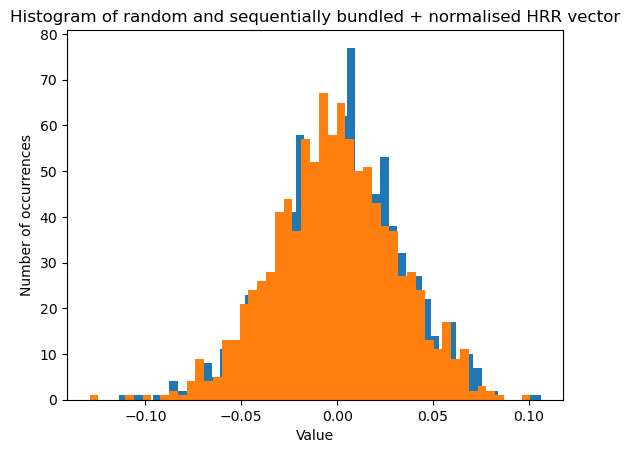

In [257]:
# histogram of single hrr vector
import matplotlib.pyplot as plt

plt.hist(first[0].cpu().numpy(), bins=50)
plt.hist(seq_bundle_vec[0].cpu().numpy(), bins=50)
plt.title('Histogram of random and sequentially bundled + normalised HRR vector')
plt.xlabel('Value')
plt.ylabel('Number of occurrences')
plt.show()

Experiment of ngram or hist statistics using sequential but non normalized bundles.

In [258]:
from ..helpers import similarity_func_partial
from functools import partial

dim = 10_000
vocab_size = 600
exp_size = 200
# vocab_size = 33_000
# exp_size = 1500
vsa_type = 'MAP'
sim_func = partial(similarity_func_partial, vsa_type)

vocab = torchhd.random(vocab_size, dim, vsa=vsa_type, device=device)
random_indices = torch.randperm(vocab_size)[:exp_size]

bundled_vec = torchhd.empty(1, dim, vsa=vsa_type, device=device)

for iteration, bundle_vec_idx in enumerate(random_indices):
    bundled_vec = bundled_vec.bundle(vocab[bundle_vec_idx])
    # for i in range(iteration):
        # bundled_vec = bundled_vec.bundle(vocab[bundle_vec_idx])
    if iteration % 100 == 0:
        print(f'iteration {iteration}')

bundled_vec_similarities = sim_func(bundled_vec, vocab[random_indices])[0].cpu().numpy()
similarities = sim_func(bundled_vec, vocab)[0].cpu().numpy()

iteration 0
iteration 100


<BarContainer object of 200 artists>

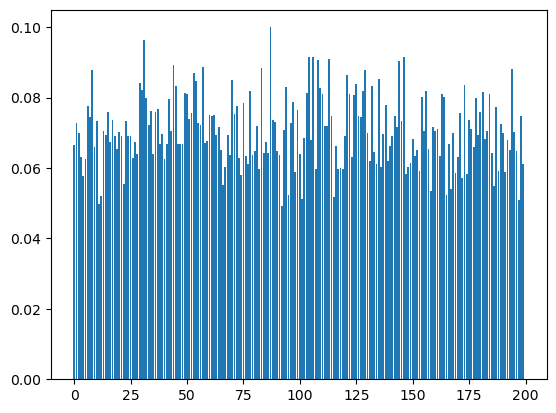

In [259]:
plt.bar(range(len(bundled_vec_similarities)), bundled_vec_similarities)

<BarContainer object of 600 artists>

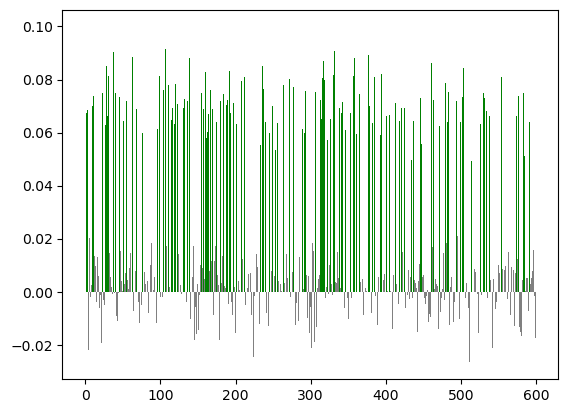

In [260]:
colors = ['green' if i in random_indices else 'gray' for i in range(len(similarities))]
plt.bar(range(len(similarities)), similarities, color=colors)